In [1]:
# https://stackoverflow.com/questions/43646550/how-to-use-an-update-function-to-animate-a-networkx-graph-in-matplotlib-2-0-0
import networkx as nx
import pandas as pd
import numpy as np
import seaborn.apionly as sns

import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator

import random as rd

TODO
- fix seed; make idempotent
- Clean up assumptions
- Clean up code (split into simulation_utils.py, visualization_utils.py)

In [22]:
# ASSUMPTIONS

# Used in random number generation; ensures results are reproducible
SEED = 42

HEALTH_STATUSES = {
    'susceptible': '#CACACA', # grey
    'infected_not_diagnosed': '#E7A1A8', #light red / pink
    'infected_diagnosed': '#EA1A30', # dark red
    'recovered': '#04FF00', # brightgreen
    'died': 'black'
}

STATISTICS_COLORS = {
    'population_susceptibility_rate': HEALTH_STATUSES['susceptible'],
    'observed_infection_rate': HEALTH_STATUSES['infected_diagnosed'],
    'population_infection_rate': HEALTH_STATUSES['infected_not_diagnosed'],
    'population_immunity_rate': HEALTH_STATUSES['recovered'],
    'population_mortality_rate': 'purple',
    'fatality_rate': HEALTH_STATUSES['died'],
    'hospital_beds': '#00F7FF',
}

PERSONS_PER_CITY = 100
CITY_N = 3
POPULATION_SIZE = PERSONS_PER_CITY * CITY_N
PROB_INFECTION_BETWEEN_NEIGHBORS = 0.4

PROB_EDGE_IN_CITY = 0.1
PROB_EDGE_OUT_CITY = 0.005

NODE_SIZE = 130
NODE_ALPHA = 0.9
EDGE_ALPHA = 0.1
LABEL_ALPHA = 1.0

POTENTIAL_CITIES = ['A', 'B', 'C', 'D', 'E']

rd.seed(SEED)

_list2d = [[POTENTIAL_CITIES[c]] * PERSONS_PER_CITY for c in list(range(0, CITY_N))]
CITY_LIST = [item for sublist in _list2d for item in sublist]

DAYS_INFECTION_TO_DIAGNOSIS = 3
DAYS_DIAGNOSIS_TO_OUTCOME = 6

# Only those whose uniformly distributed (0, 1) latent infection severity 
# percentile is above the threshold will die when infected, depending on whether 
# they can be treated in a hospital or not

INFECTION_SEVERITY_DIAGNOSIS_PERCENTILE = 0.30
# INFECTION_SEVERITY_HOSPITALIZATION_PERCENTILE = 0.60
INFECTION_SEVERITY_FATALITY_PERCENTILE_NO_HOSPITAL = 0.80
INFECTION_SEVERITY_FATALITY_PERCENTILE_HOSPITAL = 0.99

HOSPITAL_BEDS_RATIO = 0.2
AVAILABLE_HOSPITAL_BEDS = int(POPULATION_SIZE * HOSPITAL_BEDS_RATIO)

TRAVEL_PROB = 0.02

GIF_FRAME_INTERVAL = 25 # milliseconds per fram

In [5]:
# PLOTTING FUNCTIONS
def edge_color_mapping(tpl):
        if tpl[0] == 'infected_diagnosed' and not tpl[1]:
            return '#00F7FF'
        elif tpl[2]:
            return 'black'
        else:
            return 'white'

def plot_network(G, persons, date, ax, plot_labels=False, legend_keys=[]):
    pos=nx.spring_layout(G, seed=SEED)
    
    # ignore unconncted nodes, they make the plots look weird
    connected_nodes = [p.node for p in persons if len(p.neighbors) != 0]
    
    edgecolors = list(
        map(
            lambda x: edge_color_mapping(x), 
            [(p.health[date],
              p.in_hospital[date],
              p.is_practicing_social_distancing[date]) for p in persons if p.node in connected_nodes]
        )
    )   
    
    nx.draw_networkx_nodes(G, 
        nodelist=connected_nodes, 
        node_color=[HEALTH_STATUSES[p.health[date]] for p in persons if p.node in connected_nodes],
        edgecolors=edgecolors,
        node_size=NODE_SIZE,
        alpha=NODE_ALPHA,
        pos=pos, 
        ax=ax
    )
    
    legend_elements = []
    
    for status in HEALTH_STATUSES:
        if status in legend_keys:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', label=status, 
               markerfacecolor=HEALTH_STATUSES[status], markersize=15))
    
    if 'social_distancing' in legend_keys:
        legend_elements.append(Line2D([0], [0], marker='o', color='black', label='Social Distancing',
                          linewidth=0, markerfacecolor='w', markersize=12))
        
    if 'no_hospital_bed' in legend_keys:
        legend_elements.append(Line2D([0], [0], marker='o', color='#00F7FF', label='No hospital bed',
                          linewidth=0, markerfacecolor='w', markersize=12))

    nx.draw_networkx_edges(G, edge_color='lightgrey', alpha=EDGE_ALPHA, pos=pos, ax=ax);
    if plot_labels:
        # labels = dict([(p.node, int(p.infection_severity_percentile * 100)) for p in persons])
        labels = dict([(p.node, p.node) for p in persons])
        nx.draw_networkx_labels(G, labels=labels, pos=pos, alpha=LABEL_ALPHA, ax=ax, font_size=8);
    ax.set_title('Day {}'.format(date), fontsize=16)
    ax.legend(handles=legend_elements, loc='upper left')
    ax.axis('off')

    
def plot_stats(df, date, days, city, ax, keys=[], legend=True):
    colors = [STATISTICS_COLORS[k] for k in keys]
    
    tdf = df[df['date'] <= date]
    
    tdf[[k for k in keys if k != 'hospital_beds'] + ['date']].plot(
        kind='line', 
        colors=colors, 
        x='date',
        grid=True,
        ax=ax, xlim=(0, days), ylim=(-0.05, 1.05))
    
    legend_elements = []
    
    for key in keys:
        legend_elements.append(Line2D(
            [0], [0], lw=4, 
            color=STATISTICS_COLORS[key], 
            label=key)              
        )

    ax.legend(handles=legend_elements, loc='upper left')
    ax.set_xlabel('Day')
    ax.set_title('City: {}'.format(city))
    
    if 'hospital_beds' in keys:
        ax.axhline(y=HOSPITAL_BEDS_RATIO, xmin=0, xmax=days, color=STATISTICS_COLORS['hospital_beds'])
        
    
    spacing = 0.1 # This can be your user specified spacing. 
    minorLocator = MultipleLocator(spacing)

    # Set minor tick locations.
    ax.yaxis.set_minor_locator(minorLocator)
    ax.set_ylabel('% of Population')
    
    # Set grid to use minor tick locations. 
    ax.grid(which='both', color='#F1F4F4')
    
    if not legend:
        ax.get_legend().remove()

In [62]:
class Person():
    
    def __init__(self, G, node):
        
        # these attributes are immutable over time
        self.node = node
        
        self.infection_severity_percentile = rd.uniform(0, 1)
        self.travel_prob = TRAVEL_PROB
        self.neighbors = list(G.neighbors(node))
        
        # these attributes are mutable over time, only 1 value stores
        self.date = 0
        self.infected_date = None
        
        # these attributes are mutable over time; all values stored
        self.health = ['susceptible']
        self.is_practicing_social_distancing = [False]
        self.city = [CITY_LIST[node]]
        self.in_hospital = [False]
        
        
    def advance(self, Persons, sd_start_threshold_cases, sd_adoption_rate):

        # advance city
        cities_with_neighbors = set([p.city[self.date] for p in Persons if p.node in self.neighbors])
        eligible_cities = list(cities_with_neighbors - set(self.city[self.date]))
        
        travel_score = rd.uniform(0, 1)
        
        if len(eligible_cities) > 0 and travel_score < TRAVEL_PROB:    
            self.city.append(rd.choice(eligible_cities))
        else:
            self.city.append(self.city[self.date])
        
        # advance health state
        # assume person does not go to hospital; override later if they do
        self.in_hospital.append(False)
        
        occupied_hospital_beds = sum([1 for p in Persons if p.in_hospital[-1] == True])
        
        if self.health[self.date] == 'susceptible':
            
            for n in self.neighbors:
                
                # Transmission only occurs between persons in the same city    
                if (
                    Persons[n].health[self.date] in ['infected_not_diagnosed', 'infected_diagnosed'] and
                    Persons[n].city[self.date] == self.city[self.date] and
                    not Persons[n].is_practicing_social_distancing[self.date]
                ):
                  
                    # roll the dice to see if transmission occurs:
                    transmission_score = rd.uniform(0, 1)
                    
                    if transmission_score < PROB_INFECTION_BETWEEN_NEIGHBORS:
                        self.health.append('infected_not_diagnosed')
                        
                        # override for scenario when no undiagnosed infections
                        if DAYS_INFECTION_TO_DIAGNOSIS == 0:
                            self.health[self.date + 1] = 'infected_diagnosed'
                            if occupied_hospital_beds <  AVAILABLE_HOSPITAL_BEDS:
                                self.in_hospital[self.date + 1] = True
                            
                        self.infected_date = self.date + 1
                        # since a person can only be infected once, break the loop,
                        # even if there are other neighbords who could also infect the person
                        break
                    
            # if no neighbor infects the person, then append 'susceptible'
            if len(self.health) == self.date + 1:
                self.health.append('susceptible')
                    
                    
        elif self.health[self.date] == 'infected_not_diagnosed':
                
            if self.date + 1 >= self.infected_date + DAYS_INFECTION_TO_DIAGNOSIS:
                
                if self.infection_severity_percentile < INFECTION_SEVERITY_DIAGNOSIS_PERCENTILE:
                    self.health.append('recovered')
                
                else:
                    self.health.append('infected_diagnosed')

                    # allocate a hospital if beds not as of this point in loop
                    if occupied_hospital_beds <  AVAILABLE_HOSPITAL_BEDS:
                        self.in_hospital[self.date + 1] = True
                        
            else:
                self.health.append('infected_not_diagnosed')
            
        elif self.health[self.date] == 'infected_diagnosed':
            
            if self.date + 1 >= self.infected_date + DAYS_INFECTION_TO_DIAGNOSIS + DAYS_DIAGNOSIS_TO_OUTCOME:
                
                if self.in_hospital[self.date] and self.infection_severity_percentile > INFECTION_SEVERITY_FATALITY_PERCENTILE_HOSPITAL:
                    self.health.append('died')
                
                elif not self.in_hospital[self.date] and self.infection_severity_percentile > INFECTION_SEVERITY_FATALITY_PERCENTILE_NO_HOSPITAL:
                    self.health.append('died')
                    
                else:
                    self.health.append('recovered')
                
                # regardless of outcome, give up hospital bed
                self.in_hospital.append(False)
                
            else:
                self.health.append('infected_diagnosed')
                
                # keep hospital bed if you have it, otherwise give up
                if self.in_hospital[self.date]:
                    self.in_hospital[self.date + 1] = True
                else:
                    self.in_hospital[self.date + 1] = False
             
            
        elif self.health[self.date] == 'recovered':
            self.health.append('recovered')
            
        elif self.health[self.date] == 'died':
            self.health.append('died')
            
        else:
            raise ValueError('Health status of node {} at date {}: {}'.format(
                self.node, self.date, self.health[self.date]
            ))
            
            
        # decide if candidate is practicing social_distancing
        # TODO: turn into own function, simplify code
        
        # count cases diagnosed in city on self.date
        active_diagnosed_cases_in_city = sum(
            [1 for p in Persons if p.health[self.date] == 'infected_diagnosed' and p.city[self.date] == self.city[self.date]])
        
        if self.health[self.date] == 'infected_diagnosed':
            self.is_practicing_social_distancing.append(True)
            
            # override for scenario when no undiagnosed infections
            if DAYS_INFECTION_TO_DIAGNOSIS == 0:
                self.is_practicing_social_distancing[self.date + 1] = False
        
        elif self.health[self.date] in ['recovered', 'died']:
            self.is_practicing_social_distancing.append(False)
        
        elif active_diagnosed_cases_in_city >= sd_start_threshold_cases:
            
            # roll the dice to see if transmission occurs:
            sd_score = rd.uniform(0, 1)
            
            if sd_score < sd_adoption_rate:
                self.is_practicing_social_distancing.append(True)
            else:
                self.is_practicing_social_distancing.append(False)
            
        else:
            self.is_practicing_social_distancing.append(False)
            
        
        # advance the date    
        self.date += 1
   
'''
Implement this class and run simulation
'''

def summarize_stats(persons, cities, days):
    df = pd.DataFrame()
    for city in cities:
        df = df.append(summarize_city_stats(persons, days, city=city), ignore_index=True)
        
    df = df.append(summarize_city_stats(persons, days, city=None), ignore_index=True)
    
    df['observed_infection_rate'] = df['infected_diagnosed'] / df['population']

    # fatality is rate of deaths/infections, mortality is deaths/population
    df['population_susceptibility_rate'] = df['susceptible'] / df['population']

    # True infection rate
    df['population_infection_rate'] = (df['infected_diagnosed'] + df['infected_not_diagnosed']) / df['population']
    df['population_immunity_rate'] = df['recovered'] / df['population']

    try:
        df['population_mortality_rate'] = df['died'] / df['population']
        df['fatality_rate'] = df['died'] / (df['died'] + df['recovered'])
    except:
        df['population_mortality_rate'] = 0 #np.nan
        df['fatality_rate'] = 0 #np.nan
    
    return df.fillna(0)
        
        
def summarize_city_stats(persons, days, city=None):
    df = pd.DataFrame()

    for dt in range(days):
        if city is not None:
            series = [p.health[dt] for p in persons if p.city[dt] == city]
            
        else:
            series = [p.health[dt] for p in persons]
            
        df = df.append(dict(pd.Series(series).value_counts()), ignore_index=True)

    
    if city is not None:
        df['city'] = city
        df['population'] = PERSONS_PER_CITY
    else:
        df['city'] = 'All'
        df['population'] = POPULATION_SIZE
  
    return df.reset_index().rename(columns={'index':'date'}).fillna(0)


def summarize_end_state(df):
    print('Final Rates: Immunity {:.1f}%, Mortality {:.1f}%, Fatality {:.1f}%'.format(
        df.iloc[-1]['population_immunity_rate'] * 100,
        df.iloc[-1]['population_mortality_rate'] * 100,
        df.iloc[-1]['fatality_rate'] * 100,
    ))


def run_simulation(G, days=25, sd_start_threshold_cases=5, sd_adoption_rate=0.5):
    #ensure simulations are idempotent
    rd.seed(SEED)
    
    persons = []

    for node in nx.nodes(G):
        persons.append(Person(G, node))

    # Seed patient zero
    rd.seed(SEED)
    patient_zero = rd.choice(persons)
    patient_zero.health = ['infected_not_diagnosed']
    patient_zero.infected_date = 0

    # Advance through time
    for i in range(days):
        for p in persons:
            p.advance(persons, sd_start_threshold_cases, sd_adoption_rate)
    
    cities = list(set([p.city[0] for p in persons]))
    
    df = summarize_stats(persons, cities, days)
    
    summarize_end_state(df)
    
    return df, persons

### Scenario 1

Final Rates: Immunity 92.0%, Mortality 0.0%, Fatality 0.0%


/Users/samstone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


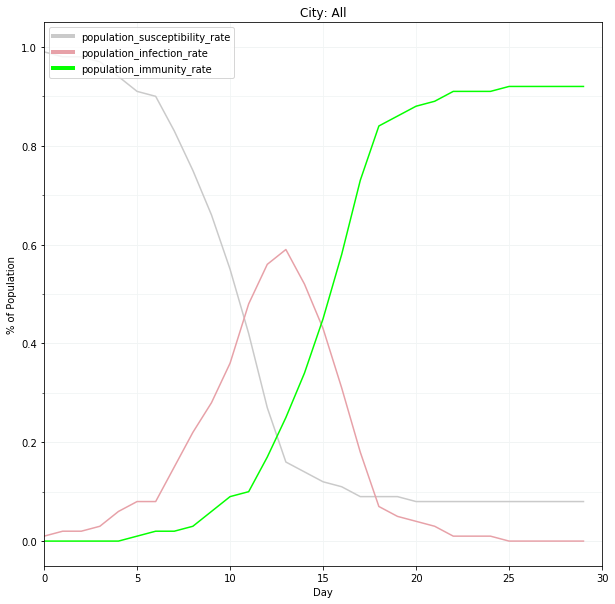

In [63]:
PERSONS_PER_CITY = 100
CITY_N = 1
POPULATION_SIZE = PERSONS_PER_CITY * CITY_N
PROB_INFECTION_BETWEEN_NEIGHBORS = 0.2

PROB_EDGE_IN_CITY = 0.05
PROB_EDGE_OUT_CITY = 0.005

DAYS_INFECTION_TO_DIAGNOSIS = 0
DAYS_DIAGNOSIS_TO_OUTCOME = 5

# Only those whose uniformly distributed (0, 1) latent infection severity 
# percentile is above the threshold will die when infected, depending on whether 
# they can be treated in a hospital or not
INFECTION_SEVERITY_DIAGNOSIS_PERCENTILE = 0.0
INFECTION_SEVERITY_FATALITY_PERCENTILE_NO_HOSPITAL = 1.0
INFECTION_SEVERITY_FATALITY_PERCENTILE_HOSPITAL = 1.0
HOSPITAL_BEDS_RATIO = 1.0
AVAILABLE_HOSPITAL_BEDS = int(POPULATION_SIZE * HOSPITAL_BEDS_RATIO)
TRAVEL_PROB = 0.00

G = nx.random_partition_graph(
    CITY_N * [PERSONS_PER_CITY], 
    PROB_EDGE_IN_CITY, 
    PROB_EDGE_OUT_CITY, 
    seed=SEED
)

days = 30

df, persons = run_simulation(G, days=days, sd_start_threshold_cases=100, sd_adoption_rate=0.75)

cities = list(set([p.city[0] for p in persons]))
    

fig, axes = plt.subplots(figsize=(10,10))

keys = [
    'population_susceptibility_rate',
#     'observed_infection_rate',
    'population_infection_rate',
    'population_immunity_rate',
#     'population_mortality_rate',
#     'fatality_rate',
#     'hospital_beds' <-- TODO: doesn't work
]

# plot_stats(df[df['city'] == cities[0]], days, days, cities[0], ax=axes[0])
# plot_stats(df[df['city'] == cities[1]], days, days, cities[1], ax=axes[1])
# plot_stats(df[df['city'] == cities[2]], days, days, cities[2], ax=axes[2])
plot_stats(df[df['city'] == 'All'], days, days, 'All', ax=axes, keys=keys)

/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


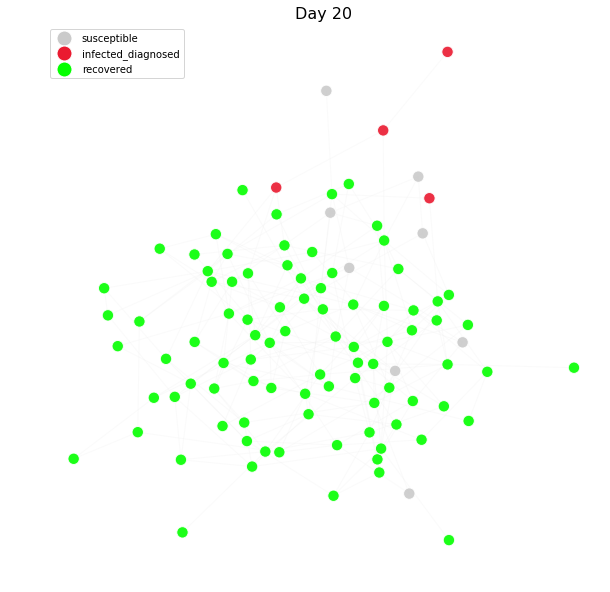

In [8]:
pos=nx.spring_layout(G, seed=SEED)
fig, ax = plt.subplots(figsize=(10,10))
plot_network(G, persons, 20, ax, legend_keys=[
    'susceptible',
#     'infected_not_diagnosed',
    'infected_diagnosed',
    'recovered',
#     'died',
#     'social_distancing',
#     'no_hospital_bed'
])

0
0
1


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


2
3


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


4
5


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


6
7


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


8
9


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


10
11


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


12
13


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


14
15


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


16


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


17


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


18


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


19


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


20


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


21


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


22


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


23


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


24


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


25


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


26


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


27


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


28


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


29


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


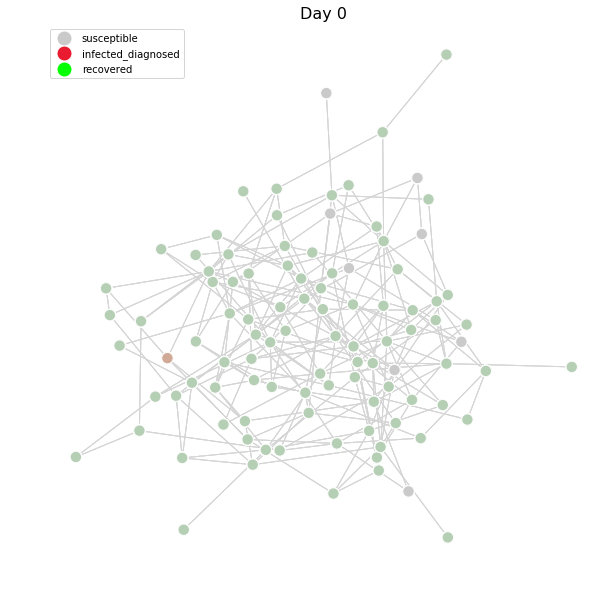

In [9]:
def update_network(ctr):
    print(ctr)
    plot_network(G, persons, ctr, ax, legend_keys=[
    'susceptible',
#     'infected_not_diagnosed',
    'infected_diagnosed',
    'recovered',
#     'died',
#     'social_distancing',
#     'no_hospital_bed'
])

pos=nx.spring_layout(G, seed=SEED)
fig, ax = plt.subplots(figsize=(10,10))

network_ani = matplotlib.animation.FuncAnimation(fig, update_network, frames=days, interval=GIF_FRAME_INTERVAL, repeat=False)
network_ani.save('network_1.gif', writer='imagemagick', fps=1)

### Scenario 2

Final Rates: Immunity 82.0%, Mortality 9.0%, Fatality 9.9%


/Users/samstone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


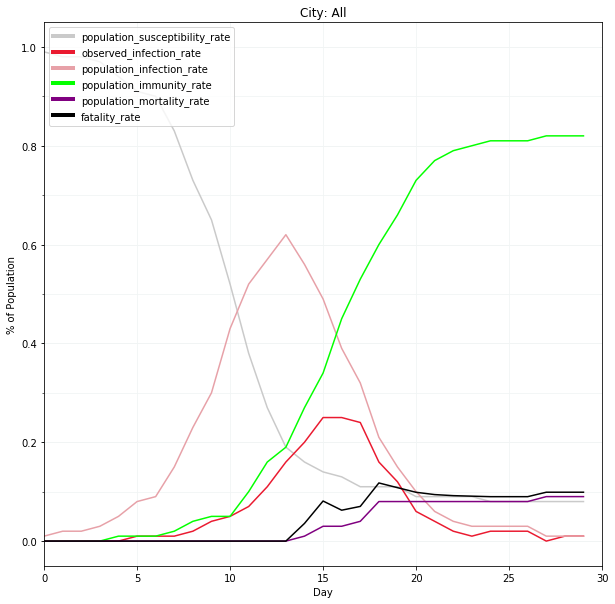

In [64]:
PERSONS_PER_CITY = 100
CITY_N = 1
POPULATION_SIZE = PERSONS_PER_CITY * CITY_N
PROB_INFECTION_BETWEEN_NEIGHBORS = 0.2

PROB_EDGE_IN_CITY = 0.05
PROB_EDGE_OUT_CITY = 0.005

DAYS_INFECTION_TO_DIAGNOSIS = 4
DAYS_DIAGNOSIS_TO_OUTCOME = 3

# Only those whose uniformly distributed (0, 1) latent infection severity 
# percentile is above the threshold will die when infected, depending on whether 
# they can be treated in a hospital or not
INFECTION_SEVERITY_DIAGNOSIS_PERCENTILE = 0.3
INFECTION_SEVERITY_FATALITY_PERCENTILE_NO_HOSPITAL = 0.9
INFECTION_SEVERITY_FATALITY_PERCENTILE_HOSPITAL = 0.9
HOSPITAL_BEDS_RATIO = 1.0
AVAILABLE_HOSPITAL_BEDS = int(POPULATION_SIZE * HOSPITAL_BEDS_RATIO)
TRAVEL_PROB = 0.00

G = nx.random_partition_graph(
    CITY_N * [PERSONS_PER_CITY], 
    PROB_EDGE_IN_CITY, 
    PROB_EDGE_OUT_CITY, 
    seed=SEED
)

days = 30

df, persons = run_simulation(G, days=days, sd_start_threshold_cases=100, sd_adoption_rate=0.75)

cities = list(set([p.city[0] for p in persons]))
    
fig, axes = plt.subplots(figsize=(10,10))

keys = [
    'population_susceptibility_rate',
    'observed_infection_rate',
    'population_infection_rate',
    'population_immunity_rate',
    'population_mortality_rate',
    'fatality_rate',
#     'hospital_beds' <-- TODO: doesn't work
]

# plot_stats(df[df['city'] == cities[0]], days, days, cities[0], ax=axes[0])
# plot_stats(df[df['city'] == cities[1]], days, days, cities[1], ax=axes[1])
# plot_stats(df[df['city'] == cities[2]], days, days, cities[2], ax=axes[2])
plot_stats(df[df['city'] == 'All'], days, days, 'All', ax=axes, keys=keys)

0
0
1


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


2
3


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


4
5


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


6
7


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


8


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


9
10


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


11


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


12


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


13


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


14


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


15


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


16


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


17


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


18


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


19


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


20


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


21


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


22


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


23


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


24


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


25


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


26


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


27


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


28


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


29


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


30


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


31


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


32


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


33


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


34


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


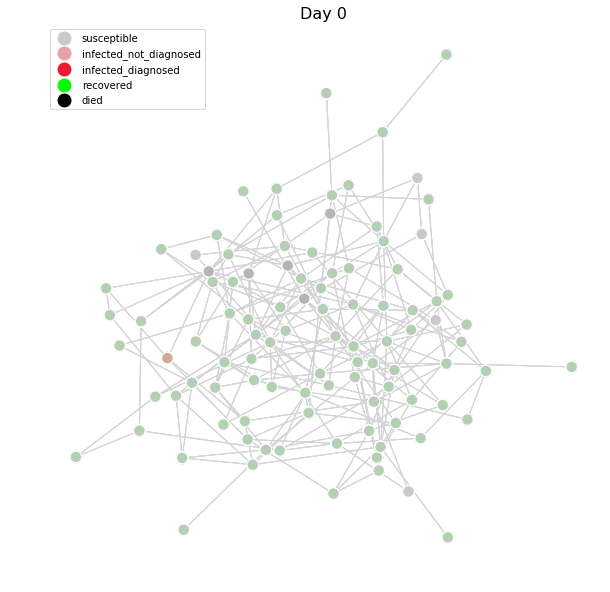

In [11]:
def update_network(ctr):
    print(ctr)
    plot_network(G, persons, ctr, ax, legend_keys=[
    'susceptible',
    'infected_not_diagnosed',
    'infected_diagnosed',
    'recovered',
    'died',
#     'social_distancing',
#     'no_hospital_bed'
])

pos=nx.spring_layout(G, seed=SEED)
fig, ax = plt.subplots(figsize=(10,10))

network_ani = matplotlib.animation.FuncAnimation(
    fig, update_network, frames=days, interval=GIF_FRAME_INTERVAL, repeat=False)
network_ani.save('network_2.gif', writer='imagemagick', fps=1)

### Scenario 3

/Users/samstone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


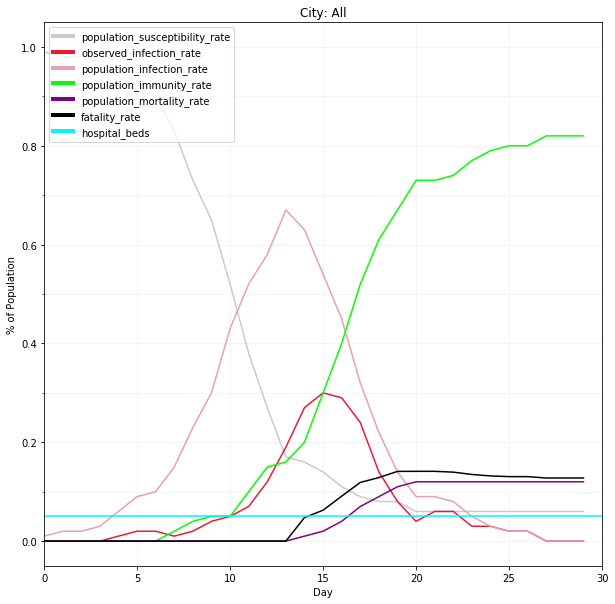

In [12]:
PERSONS_PER_CITY = 100
CITY_N = 1
POPULATION_SIZE = PERSONS_PER_CITY * CITY_N
PROB_INFECTION_BETWEEN_NEIGHBORS = 0.2

PROB_EDGE_IN_CITY = 0.05
PROB_EDGE_OUT_CITY = 0.005

DAYS_INFECTION_TO_DIAGNOSIS = 4
DAYS_DIAGNOSIS_TO_OUTCOME = 3

# Only those whose uniformly distributed (0, 1) latent infection severity 
# percentile is above the threshold will die when infected, depending on whether 
# they can be treated in a hospital or not
INFECTION_SEVERITY_DIAGNOSIS_PERCENTILE = 0.3
INFECTION_SEVERITY_FATALITY_PERCENTILE_NO_HOSPITAL = 0.8
INFECTION_SEVERITY_FATALITY_PERCENTILE_HOSPITAL = 0.95
HOSPITAL_BEDS_RATIO = 0.05
AVAILABLE_HOSPITAL_BEDS = int(POPULATION_SIZE * HOSPITAL_BEDS_RATIO)
TRAVEL_PROB = 0.00

G = nx.random_partition_graph(
    CITY_N * [PERSONS_PER_CITY], 
    PROB_EDGE_IN_CITY, 
    PROB_EDGE_OUT_CITY, 
    seed=SEED
)

days = 30

df, persons = run_simulation(G, days=days, sd_start_threshold_cases=100, sd_adoption_rate=0.75)

cities = list(set([p.city[0] for p in persons]))
    

fig, axes = plt.subplots(figsize=(10,10))

keys = [
    'population_susceptibility_rate',
    'observed_infection_rate',
    'population_infection_rate',
    'population_immunity_rate',
    'population_mortality_rate',
    'fatality_rate',
    'hospital_beds' 
]

# plot_stats(df[df['city'] == cities[0]], days, days, cities[0], ax=axes[0])
# plot_stats(df[df['city'] == cities[1]], days, days, cities[1], ax=axes[1])
# plot_stats(df[df['city'] == cities[2]], days, days, cities[2], ax=axes[2])
plot_stats(df[df['city'] == 'All'], days, days, 'All', ax=axes, keys=keys)

/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


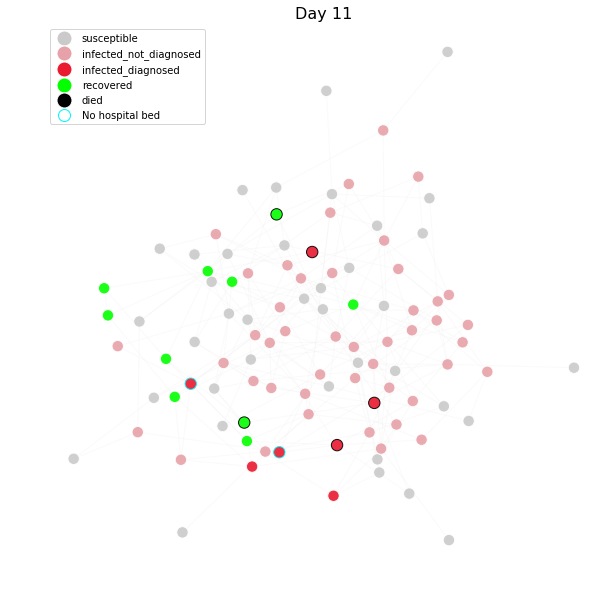

In [13]:
pos=nx.spring_layout(G, seed=SEED)
fig, ax = plt.subplots(figsize=(10,10))
plot_network(G, persons, 11, ax, legend_keys=[
    'susceptible',
    'infected_not_diagnosed',
    'infected_diagnosed',
    'recovered',
    'died',
#     'social_distancing',
    'no_hospital_bed'
])

0
0
1


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


2
3


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


4
5


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


6


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


7
8


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


9
10
11


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


12


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


13


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


14


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


15


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


16


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


17


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


18


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


19


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


20


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


21


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


22


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


23


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


24


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


25


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


26


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


27


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


28


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


29


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


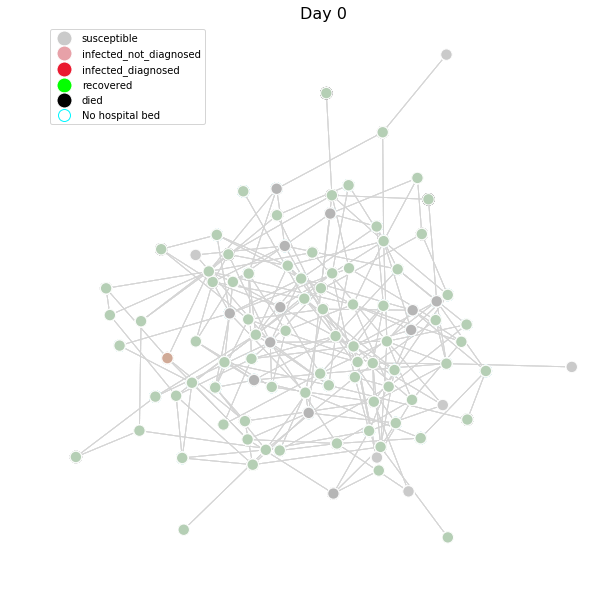

In [14]:
def update_network(ctr):
    print(ctr)
    plot_network(G, persons, ctr, ax, legend_keys=[
    'susceptible',
    'infected_not_diagnosed',
    'infected_diagnosed',
    'recovered',
    'died',
#     'social_distancing',
    'no_hospital_bed'
])

pos=nx.spring_layout(G, seed=SEED)
fig, ax = plt.subplots(figsize=(10,10))

network_ani = matplotlib.animation.FuncAnimation(
    fig, update_network, frames=days, interval=GIF_FRAME_INTERVAL, repeat=False)
network_ani.save('network_3.gif', writer='imagemagick', fps=1)

### Scenario 4

/Users/samstone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


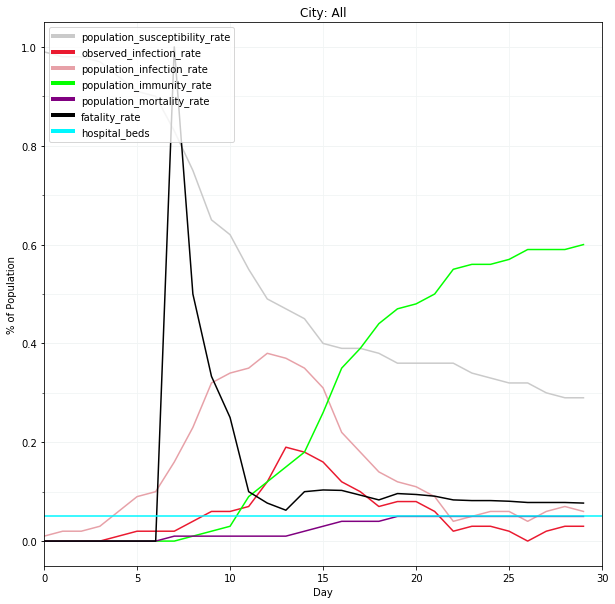

In [15]:
PERSONS_PER_CITY = 100
CITY_N = 1
POPULATION_SIZE = PERSONS_PER_CITY * CITY_N
PROB_INFECTION_BETWEEN_NEIGHBORS = 0.2

PROB_EDGE_IN_CITY = 0.05
PROB_EDGE_OUT_CITY = 0.005

DAYS_INFECTION_TO_DIAGNOSIS = 4
DAYS_DIAGNOSIS_TO_OUTCOME = 3

# Only those whose uniformly distributed (0, 1) latent infection severity 
# percentile is above the threshold will die when infected, depending on whether 
# they can be treated in a hospital or not
INFECTION_SEVERITY_DIAGNOSIS_PERCENTILE = 0.3
INFECTION_SEVERITY_FATALITY_PERCENTILE_NO_HOSPITAL = 0.8
INFECTION_SEVERITY_FATALITY_PERCENTILE_HOSPITAL = 0.95
HOSPITAL_BEDS_RATIO = 0.05
AVAILABLE_HOSPITAL_BEDS = int(POPULATION_SIZE * HOSPITAL_BEDS_RATIO)
TRAVEL_PROB = 0.00

G = nx.random_partition_graph(
    CITY_N * [PERSONS_PER_CITY], 
    PROB_EDGE_IN_CITY, 
    PROB_EDGE_OUT_CITY, 
    seed=SEED
)

days = 30

df, persons = run_simulation(G, days=days, sd_start_threshold_cases=3, sd_adoption_rate=0.7)

cities = list(set([p.city[0] for p in persons]))
    

fig, axes = plt.subplots(figsize=(10,10))

keys = [
    'population_susceptibility_rate',
    'observed_infection_rate',
    'population_infection_rate',
    'population_immunity_rate',
    'population_mortality_rate',
    'fatality_rate',
    'hospital_beds' 
]

# plot_stats(df[df['city'] == cities[0]], days, days, cities[0], ax=axes[0])
# plot_stats(df[df['city'] == cities[1]], days, days, cities[1], ax=axes[1])
# plot_stats(df[df['city'] == cities[2]], days, days, cities[2], ax=axes[2])
plot_stats(df[df['city'] == 'All'], days, days, 'All', ax=axes, keys=keys)

/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


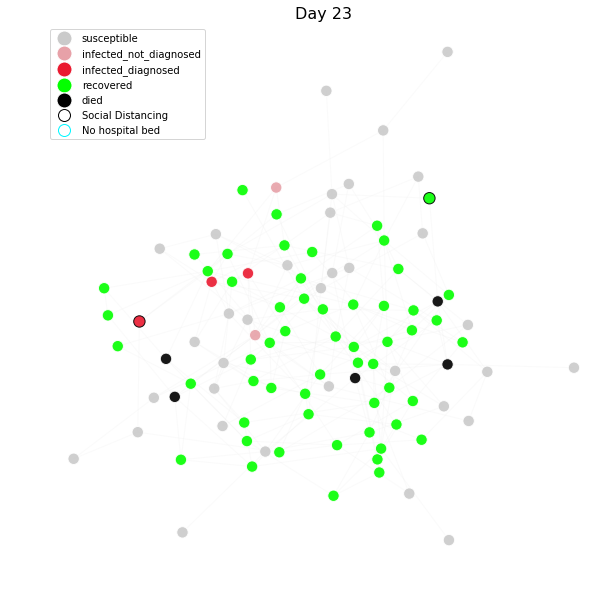

In [16]:
pos=nx.spring_layout(G, seed=SEED)
fig, ax = plt.subplots(figsize=(10,10))
plot_network(G, persons, 23, ax, legend_keys=[
    'susceptible',
    'infected_not_diagnosed',
    'infected_diagnosed',
    'recovered',
    'died',
    'social_distancing',
    'no_hospital_bed'
])

0
0


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


1
2


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


3


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


4
5


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


6
7


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


8


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


9


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


10


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


11


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


12


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


13


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


14


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


15


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


16


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


17


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


18


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


19


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


20


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


21


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


22


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


23


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


24


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


25


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


26


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


27


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


28


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


29


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


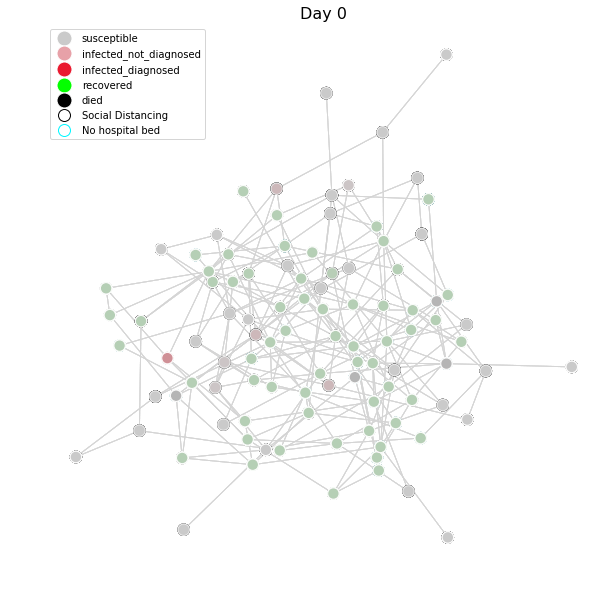

In [17]:
def update_network(ctr):
    print(ctr)
    plot_network(G, persons, ctr, ax, legend_keys=[
    'susceptible',
    'infected_not_diagnosed',
    'infected_diagnosed',
    'recovered',
    'died',
    'social_distancing',
    'no_hospital_bed'
])

pos=nx.spring_layout(G, seed=SEED)
fig, ax = plt.subplots(figsize=(10,10))

network_ani = matplotlib.animation.FuncAnimation(
    fig, update_network, frames=days, interval=GIF_FRAME_INTERVAL, repeat=False)
network_ani.save('network_4.gif', writer='imagemagick', fps=1)

### Scenario 5

/Users/samstone/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/samstone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
/Users/samstone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
/Users/samstone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn

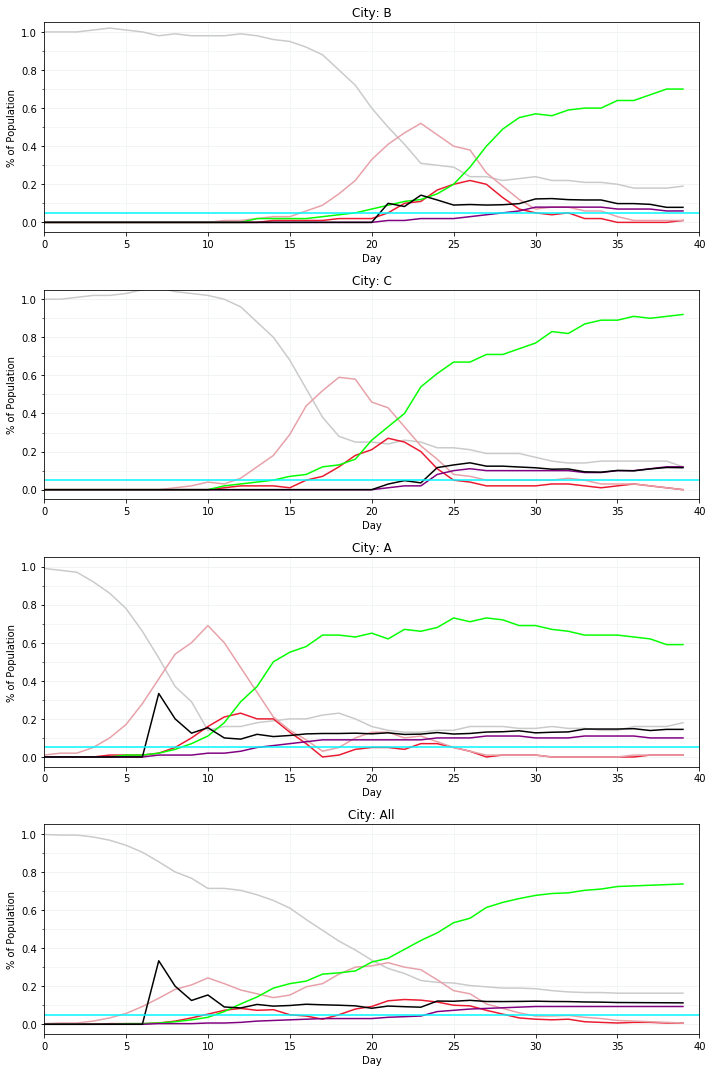

In [18]:
PERSONS_PER_CITY = 100
CITY_N = 3
POPULATION_SIZE = PERSONS_PER_CITY * CITY_N
PROB_INFECTION_BETWEEN_NEIGHBORS = 0.3

PROB_EDGE_IN_CITY = 0.05
PROB_EDGE_OUT_CITY = 0.002

DAYS_INFECTION_TO_DIAGNOSIS = 4
DAYS_DIAGNOSIS_TO_OUTCOME = 3

# Only those whose uniformly distributed (0, 1) latent infection severity 
# percentile is above the threshold will die when infected, depending on whether 
# they can be treated in a hospital or not
INFECTION_SEVERITY_DIAGNOSIS_PERCENTILE = 0.3
INFECTION_SEVERITY_FATALITY_PERCENTILE_NO_HOSPITAL = 0.8
INFECTION_SEVERITY_FATALITY_PERCENTILE_HOSPITAL = 0.95
HOSPITAL_BEDS_RATIO = 0.05
AVAILABLE_HOSPITAL_BEDS = int(POPULATION_SIZE * HOSPITAL_BEDS_RATIO)
TRAVEL_PROB = 0.03

G = nx.random_partition_graph(
    CITY_N * [PERSONS_PER_CITY], 
    PROB_EDGE_IN_CITY, 
    PROB_EDGE_OUT_CITY, 
    seed=SEED
)

days = 40

df, persons = run_simulation(G, days=days, sd_start_threshold_cases=6, sd_adoption_rate=0.7)

cities = list(set([p.city[0] for p in persons]))
    
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,15))

keys = [
    'population_susceptibility_rate',
    'observed_infection_rate',
    'population_infection_rate',
    'population_immunity_rate',
    'population_mortality_rate',
    'fatality_rate',
    'hospital_beds' 
]

plot_stats(df[df['city'] == cities[0]], days, days, cities[0], ax=axes[0], keys=keys, legend=False)
plot_stats(df[df['city'] == cities[1]], days, days, cities[1], ax=axes[1], keys=keys, legend=False)
plot_stats(df[df['city'] == cities[2]], days, days, cities[2], ax=axes[2], keys=keys, legend=False)
plot_stats(df[df['city'] == 'All'], days, days, 'All', ax=axes[3], keys=keys, legend=False)

fig.tight_layout()

/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


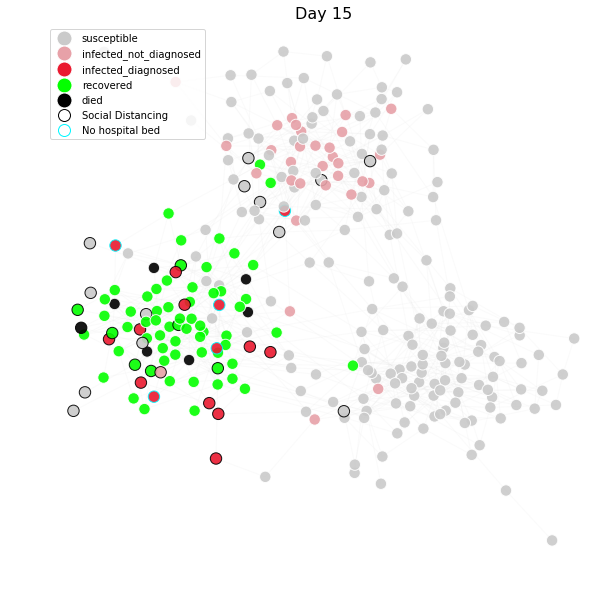

In [19]:
pos=nx.spring_layout(G, seed=SEED)
fig, ax = plt.subplots(figsize=(10,10))
plot_network(G, persons, 15, ax, plot_labels=False, legend_keys=[
    'susceptible',
    'infected_not_diagnosed',
    'infected_diagnosed',
    'recovered',
    'died',
    'social_distancing',
    'no_hospital_bed'
])

0


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


1


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


2


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


3


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


4


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


5


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


6


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


7


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


8


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


9


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


10


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


11


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


12


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


13


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


14


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


15


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


16


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


17


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


18


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


19


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


20


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


21


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


22


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


23


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


24


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


25


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


26


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


27


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


28


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


29


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


30


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


31


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


32


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


33


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


34


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


35


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


36


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


37


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


38


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


39


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0


/Users/samstone/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


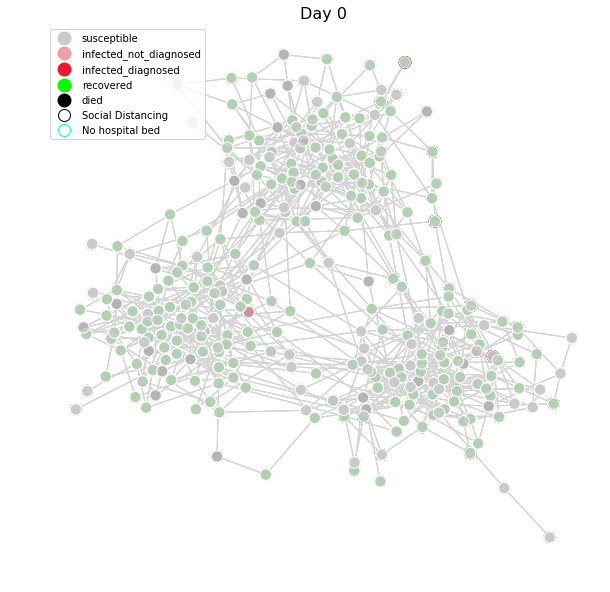

In [20]:
def update_network(ctr):
    print(ctr)
    plot_network(G, persons, ctr, ax, legend_keys=[
    'susceptible',
    'infected_not_diagnosed',
    'infected_diagnosed',
    'recovered',
    'died',
    'social_distancing',
    'no_hospital_bed'
])

pos=nx.spring_layout(G, seed=SEED)
fig, ax = plt.subplots(figsize=(10,10))

network_ani = matplotlib.animation.FuncAnimation(
    fig, update_network, frames=days, interval=GIF_FRAME_INTERVAL, repeat=False)
network_ani.save('network_5.gif', writer='imagemagick', fps=1)

In [21]:
# def update_stats(ctr):
#     plot_stats(Persons, ctr, ax)

# fig, ax = plt.subplots(figsize=(10,10))

# stats_ani = matplotlib.animation.FuncAnimation(fig, update_stats, frames=DAYS, interval=100, repeat=False)
# stats_ani.save('stats_sd_{}.gif'.format(TOGGLE_SOCIAL_DISTANCING), writer='imagemagick', fps=1)